In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from pyspark import SparkContext

In [2]:
mxm_data = sc.pickleFile("../data/mxm_dataset_all/")
mbz_data = sc.pickleFile("../data/musicbrainz-songs/").map(lambda x: (x[0], {'year': x[1]['year'][0]}))
metadata = sc.pickleFile("../data/metadata-songs/").map(lambda x: (x[0], {'hotness': x[1]['song_hotttnesss'][0]}))

In [3]:
def flattenDicts(ls):
    if len(ls) > 1:
        acc = ls[0].copy()
        for x in ls[1:]:
            acc.update(x)
        return acc
    else:
        return ls[0]

In [4]:
rdd = metadata.join(mbz_data).map(lambda x: (x[0], flattenDicts(x[1]))).join(mxm_data).map(lambda x: (x[0], flattenDicts(x[1])))

In [5]:
def weigh_occ_by_hotness(x):
    ls = []
    hn = x[1]['hotness'] + 1
    if np.isnan(hn):
        hn = 1
    for k in x[1]['words']:
        ls.append((k[0], k[1] * hn))
    x[1]['words'] = ls
    return x

weighted_rdd = rdd.filter(lambda x: not np.isnan(x[1]['hotness'])).map(weigh_occ_by_hotness)
weighted_rdd.first()

('TRAYYAU128F92D58D0',
 {'TrackID': u'7074404',
  'hotness': 0.39200877147130697,
  'words': [(u'the', 4.1760263144139209),
   (u'you', 5.5680350858852279),
   (u'to', 2.7840175429426139),
   (u'and', 5.5680350858852279),
   (u'a', 6.9600438573565349),
   (u'not', 9.7440614002991488),
   (u'of', 2.7840175429426139),
   (u'that', 1.392008771471307),
   (u'on', 2.7840175429426139),
   (u'will', 11.136070171770456),
   (u'no', 1.392008771471307),
   (u'have', 1.392008771471307),
   (u'but', 1.392008771471307),
   (u'with', 4.1760263144139209),
   (u'just', 4.1760263144139209),
   (u'like', 1.392008771471307),
   (u'there', 1.392008771471307),
   (u'they', 1.392008771471307),
   (u'out', 5.5680350858852279),
   (u'down', 1.392008771471307),
   (u'he', 13.92008771471307),
   (u'make', 2.7840175429426139),
   (u'take', 2.7840175429426139),
   (u'as', 1.392008771471307),
   (u'ca', 5.5680350858852279),
   (u'by', 4.1760263144139209),
   (u'her', 5.5680350858852279),
   (u'heart', 4.1760263144

In [6]:
def aggWordCount(localRes, newElem):
    if len(localRes) == 0:
        res = {}
        for (k, v) in newElem[1]:
            res[k] = v
        return res
    else:
        for (k, v) in newElem[1]:
            if k in localRes:
                localRes[k] += v
            else:
                localRes[k] = v
        return localRes
    
def combResults(a, b):
    if len(a) == 0:
        return b
    else:
        res = {}
        for k in a:
            res[k] = a[k]
        for k in b:
            if k in res:
                res[k] += b[k]
            else:
                res[k] = b[k]
        return res

In [7]:
cnts = rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)

weighted_cnts = weighted_rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)

In [8]:
# This list is taken from the sklearn stop_words package
# https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
# which in turn is taken from the Glasgow Information Retrieval Group 
# http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words
ENGLISH_STOP_WORDS = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
"yourselves"]

stemmed_stop_words = ['onli', 'whi', 'somethi']

In [9]:
def filter_occ_totals(occurences):
    acc = {}

    for k in occurences:
        if k not in stemmed_stop_words and k not in ENGLISH_STOP_WORDS:
            acc[k] = occurences[k]
    
    return acc

In [10]:
filtered_cnts = filter_occ_totals(cnts)

weighted_filtered_cnts = filter_occ_totals(weighted_cnts)

In [11]:
s = sorted(filtered_cnts, key=filtered_cnts.get, reverse=True)
    
for k in s[:20]:
    print(k, ": ", filtered_cnts[k])

(u'love', ': ', 3280)
(u'know', ': ', 2999)
(u'like', ': ', 2669)
(u'just', ': ', 2445)
(u'come', ': ', 2216)
(u'oh', ': ', 2037)
(u'got', ': ', 2034)
(u'time', ': ', 1794)
(u'que', ': ', 1721)
(u'let', ': ', 1718)
(u'say', ': ', 1613)
(u'babi', ': ', 1594)
(u'want', ': ', 1566)
(u'make', ': ', 1527)
(u'yeah', ': ', 1447)
(u'way', ': ', 1349)
(u'feel', ': ', 1349)
(u'ca', ': ', 1346)
(u'la', ': ', 1317)
(u'caus', ': ', 1249)


Let's plot the distribution of 

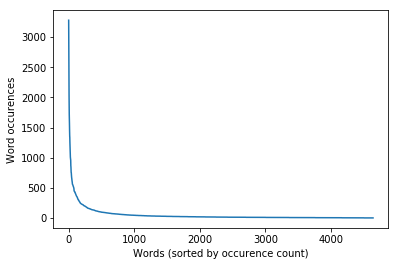

In [12]:
plt.plot(range(0, len(filtered_cnts)), [filtered_cnts[k] for k in s])
plt.xlabel("Words (sorted by occurence count)")
plt.ylabel("Word occurences")
plt.show()

As expected, we are faced with a [Pareto distribution](https://en.wikipedia.org/wiki/Zipf%27s_law).

## WordCloud

We will now generate a word cloud from these word occurences to visualize the frequencies in a different way.

In [13]:
def make_wordcloud(occurences, fname=None, mask=None):
    try:
        import wordcloud

        wc = wordcloud.WordCloud(width=2000, height=1500, max_words=1000, mask=mask, random_state = 2)
        wc.generate_from_frequencies(occurences)
        
        if fname is not None:
            plt.imsave(fname, wc)

        plt.figure(figsize=[15,15])
        plt.imshow(wc)
        plt.axis('off')
        plt.show()
    except ImportError:
        print("wordcloud package not installed, use `pip install wordcloud`")

In [14]:
note_mask = plt.imread('../data/note.png', format='I')

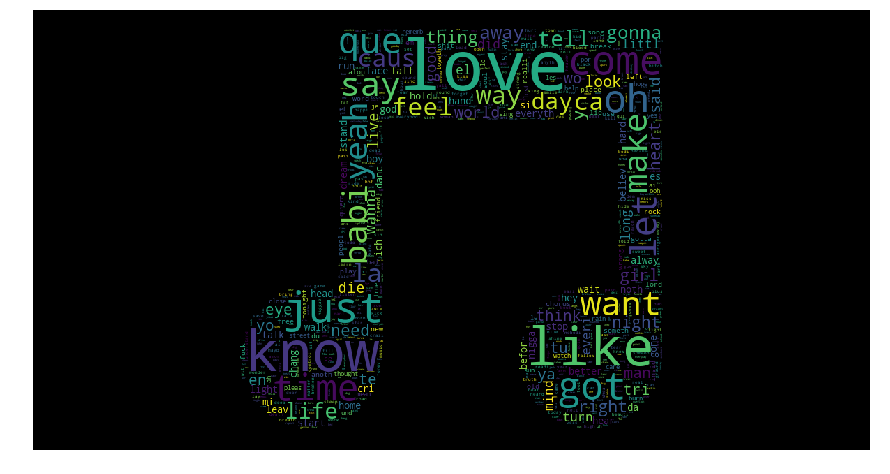

In [15]:
make_wordcloud(filtered_cnts, mask=note_mask)

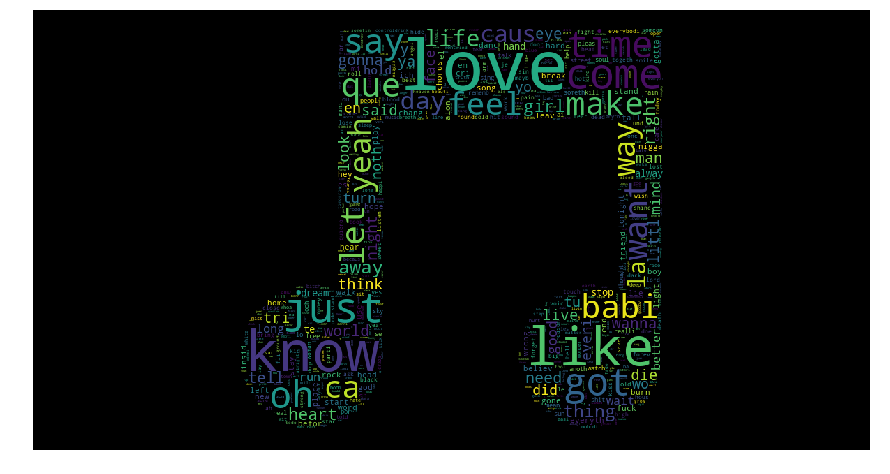

In [16]:
make_wordcloud(weighted_filtered_cnts, mask=note_mask)

### Time year slices

Year 1950


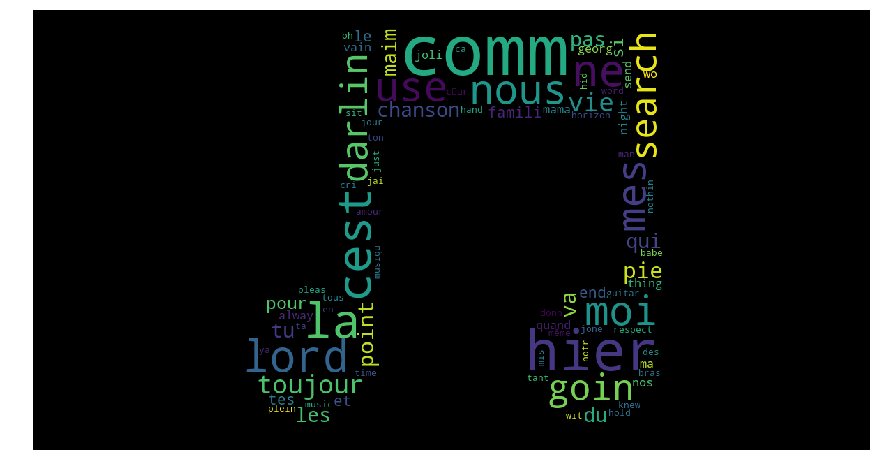

Year 1955


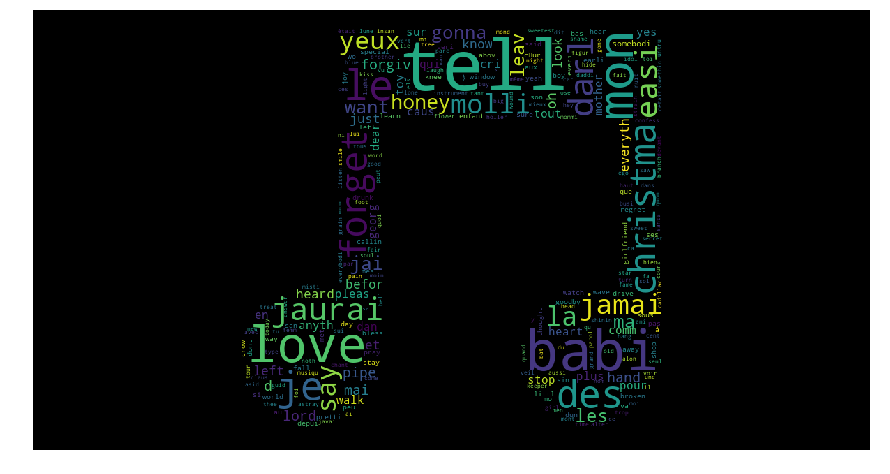

Year 1960


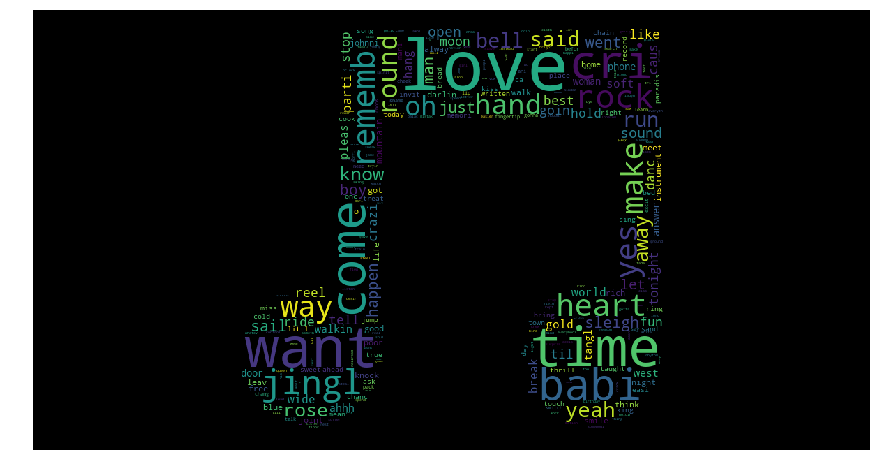

Year 1965


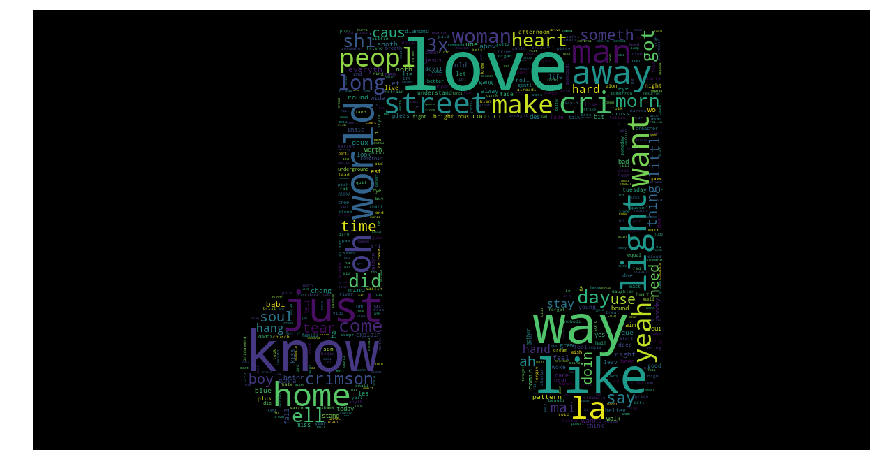

Year 1970


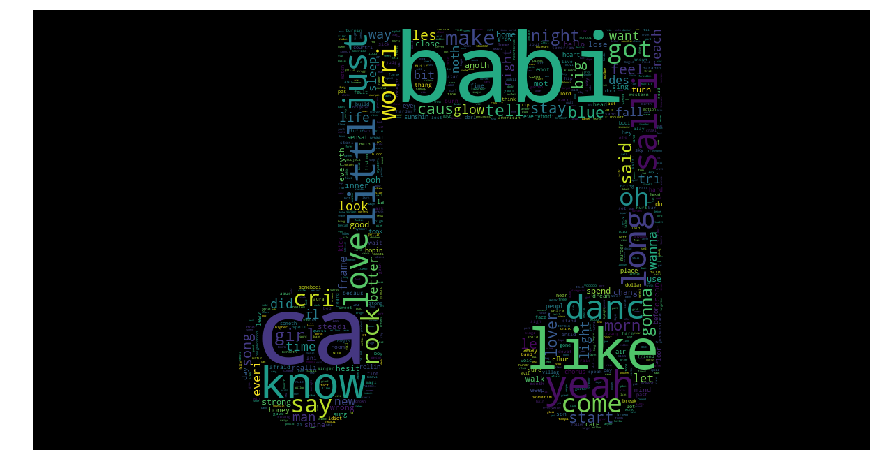

Year 1975


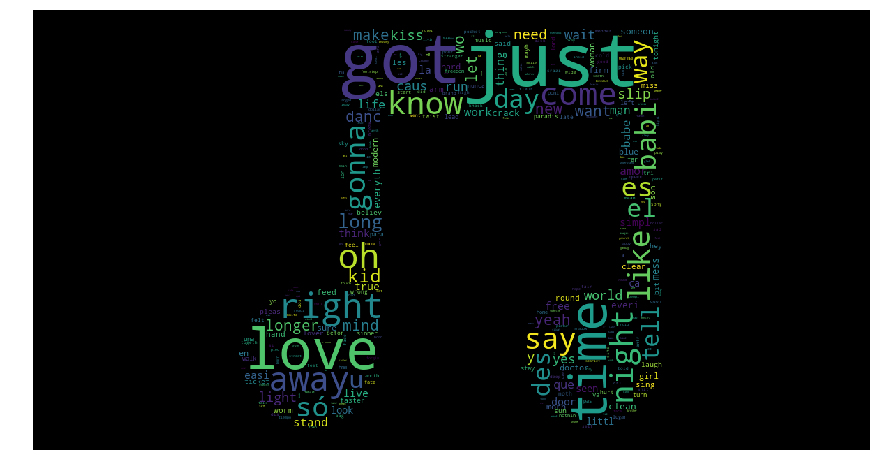

Year 1980


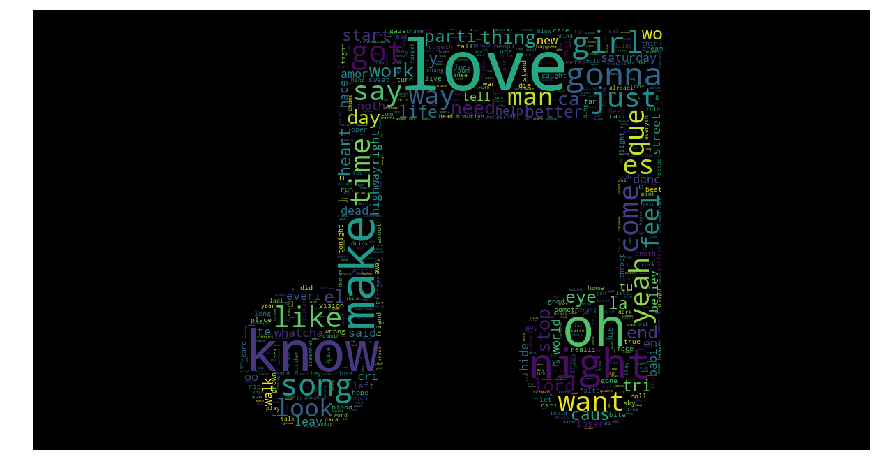

Year 1985


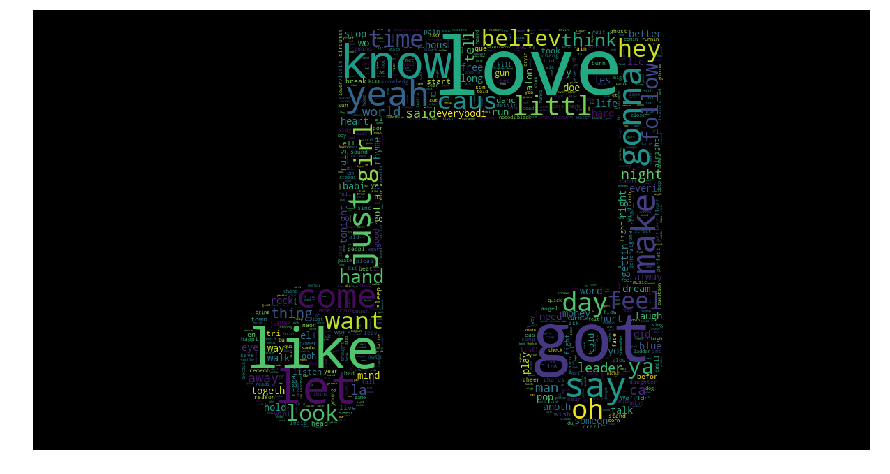

Year 1990


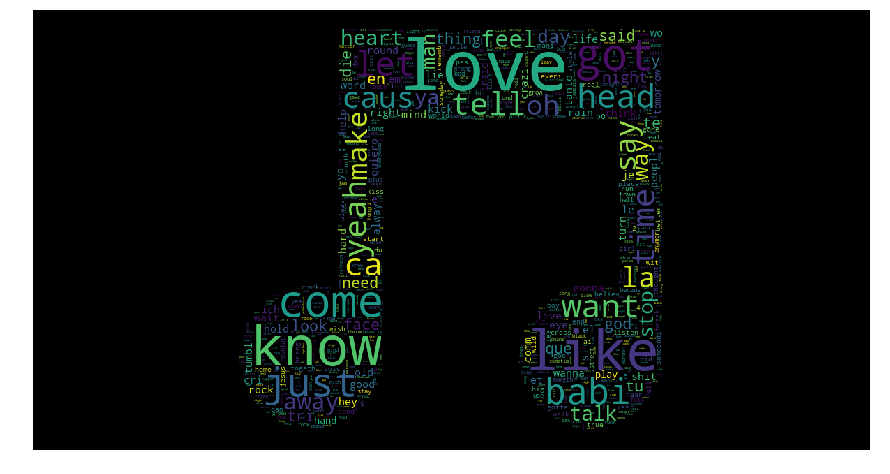

Year 1995


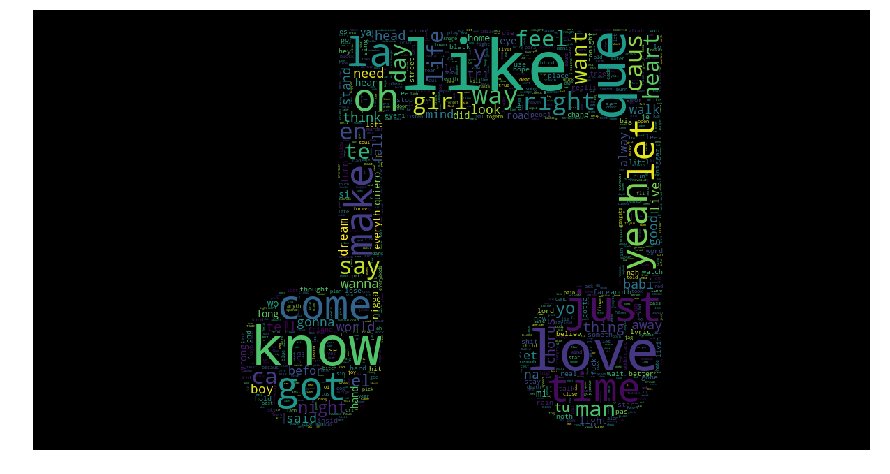

Year 2000


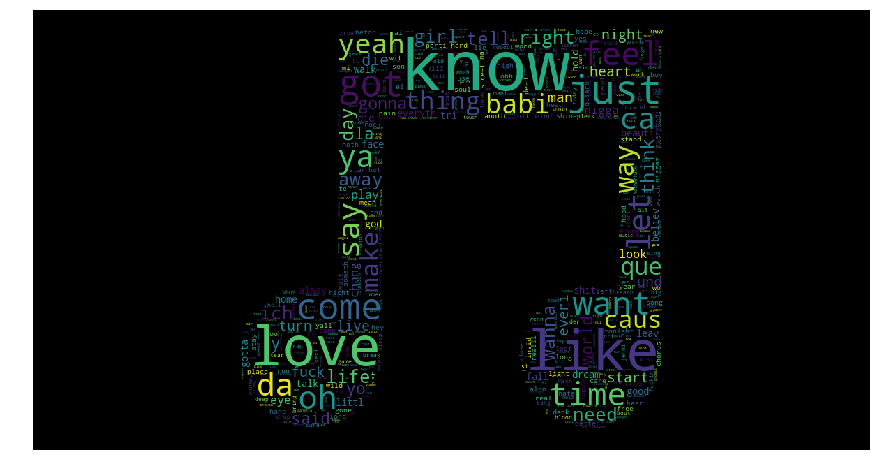

Year 2005


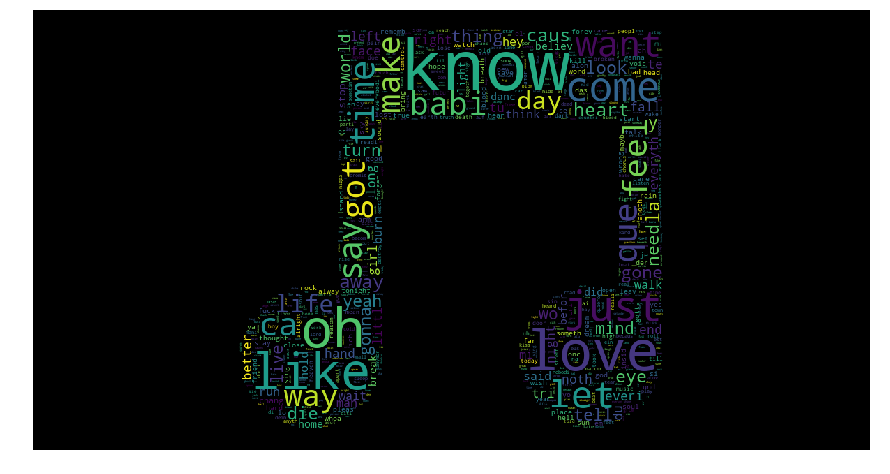

Year 2010


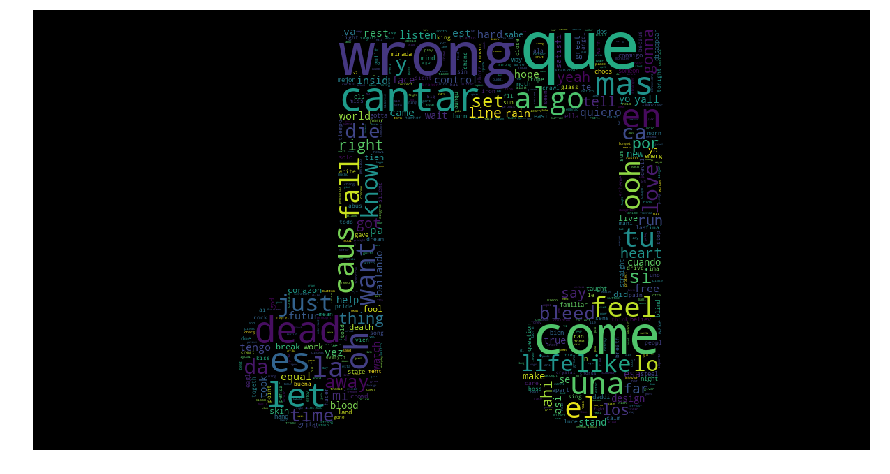

Year 2015


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [18]:
step = 5

for year in range(1950, 2020, step):
    year_rdd = rdd.filter(lambda x: x[1]["year"] >= year and x[1]["year"] < year+step)
    year_cnts = year_rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)
    filtered_year_cnts = filter_occ_totals(year_cnts)
    print("Year %d" % year)
    make_wordcloud(filtered_year_cnts, mask=note_mask)